<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/main/AD_LTEM_sim_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [2]:
!git clone https://github.com/danielzt12/AD_LTEM

fatal: destination path 'AD_LTEM' already exists and is not an empty directory.


In [75]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import signal as tfs
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys, time
from scipy.fftpack import *
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
from scipy import ndimage
from google.colab import output
import tifffile as tif
import gdown

sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla T4


In [612]:
# truth for amplitude and phase

true_amplitude =  tif.imread('AD_LTEM/design_amp.tiff')
true_phase = tif.imread('AD_LTEM/design_tphi.tiff')
true_phase -= true_phase.mean()

In [122]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 15
# there are 65 defocus images equally distributed between -1.6 mm and 1.6 mm
defocus = np.linspace(-1.6e6,1.6e6,65)

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l
To: /content/amplitude4TIE_noise15.npy
136MB [00:01, 134MB/s]
estimated noise from transparent region : 16.9%


Text(0.5, 1.0, '1600000.0 nm')

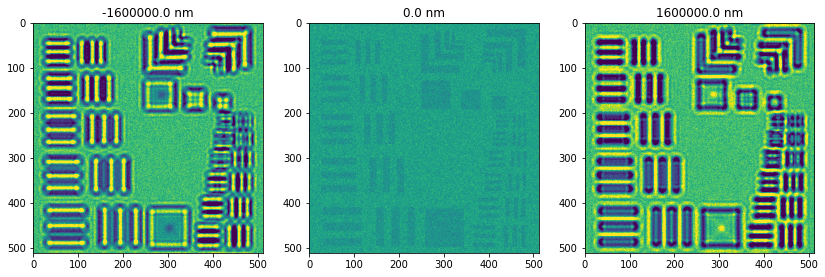

In [123]:
f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[32], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[1].set_title("{0} nm".format(defocus[32]))
ax[2].imshow(A_samples[64], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[2].set_title("{0} nm".format(defocus[64]))

In [68]:
# generate microscopic transfer function

from microscopes_fwd import Microscope

defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = ampli_sample.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex64)
for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)
 

#A_samples /= A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

# Phase Retrieval

In [491]:
# for 4 images, download the data with 14% noise
!gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
A_samples = np.load("amplitude4TIE_noise14.npy")

Downloading...
From: http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf
To: /content/amplitude4TIE_noise14.npy
136MB [00:01, 92.1MB/s]


In [493]:
selection = [28,30,62,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]

chosen defocus (mm):  [-0.2 -0.1  1.5  1.6]


In [494]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*TF)

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2)

  gerr = losses
  return losses


In [495]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

In [496]:
tot_errs = []
tot_accs = []

lr = .8
max_iter = 10000
t1=time.time()
result=optimize(1e-9,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

total elapsed time 381.9 s for 2899 iterations: 
final err 0.0039931610226631165
final acc 0.955 
max acc 0.955 at iteration #2899: 


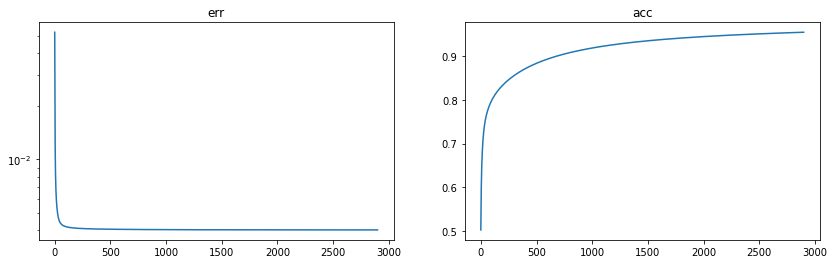

In [497]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(result[1])
ax[0].set_title("err")
ax[1].plot(result[2])
ax[1].set_title("acc");

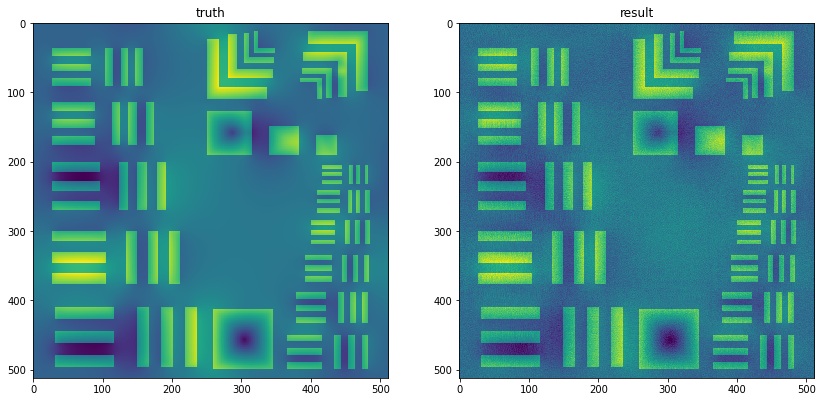

In [498]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

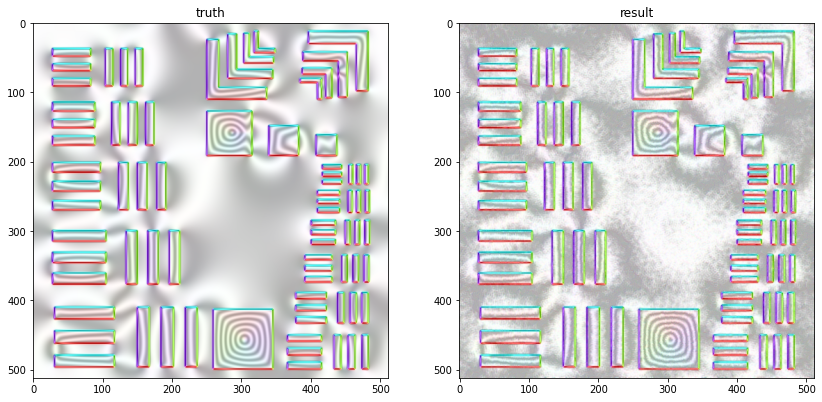

In [500]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),1,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

# With Total Variation Regularizer

In [501]:
# test on 2 defocus images

!gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
A_samples = np.load("amplitude4TIE_noise10.npy")

Downloading...
From: http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk
To: /content/amplitude4TIE_noise10.npy
136MB [00:00, 188MB/s]


In [502]:
selection = [0,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]

chosen defocus (mm):  [-1.6  1.6]


In [503]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*TF)

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2) + lamb*tf.image.total_variation(tf.expand_dims(guess_phase,axis=-1))

  gerr = losses
  return losses


In [504]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []

  for i in (range(max_iter)):
    opt = tf.optimizers.Adam(learning_rate=lr)
    train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    if i>10:
      if np.abs(errs[-1]-errs[-2]) < tol:
        break
    i += 1

  return result_phase, np.array(errs), np.array(accs), i

In [505]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

In [506]:
tot_errs = []
tot_accs = []

lr = .8
lamb = 4e-8
max_iter = 10000
t1=time.time()
result=optimize(1e-9,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

total elapsed time 91.6 s for 699 iterations: 
final err 0.004029039293527603
final acc 0.979 
max acc 0.979 at iteration #699: 


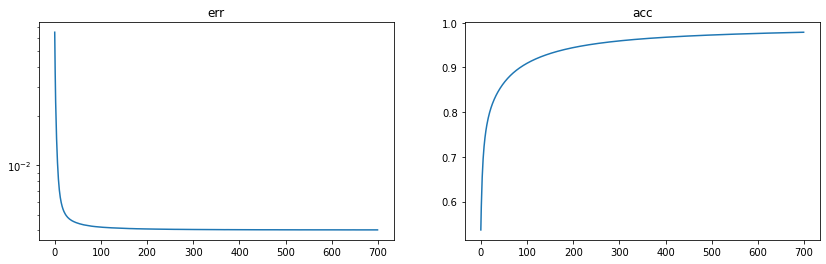

In [507]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(result[1])
ax[0].set_title("err")
ax[1].plot(result[2])
ax[1].set_title("acc");

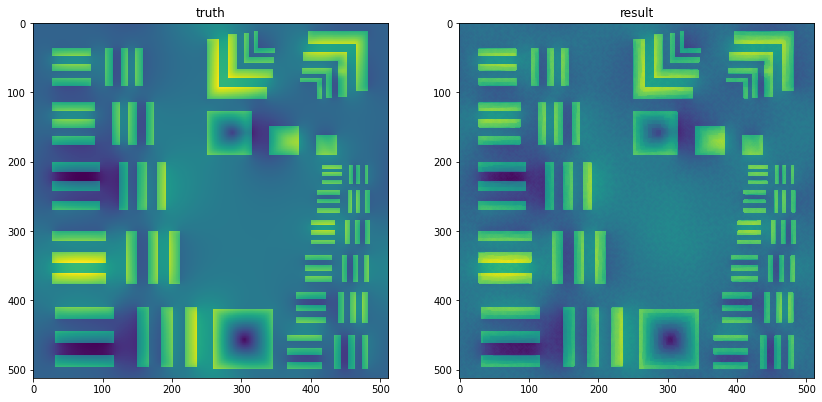

In [508]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

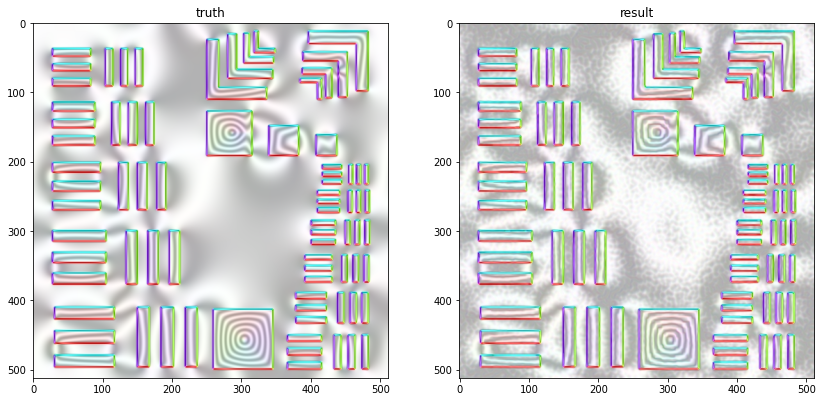

In [512]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),1,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

# GS-optimization

In [758]:
# test on 2 defocus images

!gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
A_samples = np.load("amplitude4TIE_noise0.npy")

Downloading...
From: http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk
To: /content/amplitude4TIE_noise10.npy
136MB [00:01, 104MB/s]


In [775]:
selection = [30,34]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]

chosen defocus (mm):  [-0.1  0.1]


In [776]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False)
#guess_amplitude = np.copy(A_samples[32])
#guess_amplitude = np.copy(true_amplitude)
#guess_amplitude /= guess_amplitude.mean()
# initialize the phase as 0.5 everywhere
guess_phase = np.zeros(A_samples[32].shape)+0.5
#guess_phase = np.copy(true_phase)


In [ ]:
max_iter = 36000
accs = []

obj_new = (guess_amplitude * np.exp(1j*guess_phase))
t0 = time.time()
for i in range(max_iter):
  cal_phase = np.angle(ifft2(fft2(obj_new)*TF))
  exp_new = exp_data * np.exp(1j*cal_phase)
  obj_new = ifft2(fft2(exp_new)/TF)
  guess_phase = np.angle(obj_new)[1]
  guess_phase -= guess_phase.mean()
  obj_new = (guess_amplitude * np.exp(1j*guess_phase))
  acc = (guess_phase*true_phase).sum() / np.sqrt((guess_phase*guess_phase).sum() * (true_phase*true_phase).sum())
  accs.append(acc)

print(time.time()-t0)
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(guess_phase)
ax[1].plot(accs)


In [764]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False)
#guess_amplitude = np.copy(A_samples[32])
#guess_amplitude = np.copy(true_amplitude)
#guess_amplitude /= guess_amplitude.mean()
# initialize the phase as 0.5 everywhere
guess_phase = np.zeros(A_samples[32].shape)+0.5
#guess_phase = np.copy(true_phase)

TF2 = np.copy(TF).astype(np.complex256) # to avoid numerical error by division
TF2[np.abs(TF)<1e-13]=1e7

In [ ]:
obj_new = (guess_amplitude * np.exp(1j*guess_phase)).astype(np.complex256)
cal_phase = np.angle(ifft2(fft2(obj_new)*TF))
exp_new = exp_data * np.exp(1j*cal_phase)
test2 = ifft2(fft2(exp_new)/TF2)[0]
test1 = obj_new


f, ax = plt.subplots(ncols=2,nrows=2, figsize = (14,14))
ax[0,0].imshow(np.abs(test1), interpolation='none', norm=colors.LogNorm())
ax[0,0].set_title("truth")
ax[1,0].imshow(np.abs(test2), interpolation='none', norm=colors.LogNorm(np.abs(test1).min(),np.abs(test1).max()))
ax[1,0].set_title("result")
ax[0,1].imshow(np.angle(test1), interpolation='none')
ax[0,1].set_title("truth")
ax[1,1].imshow(np.angle(test2), interpolation='none')
ax[1,1].set_title("result");

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


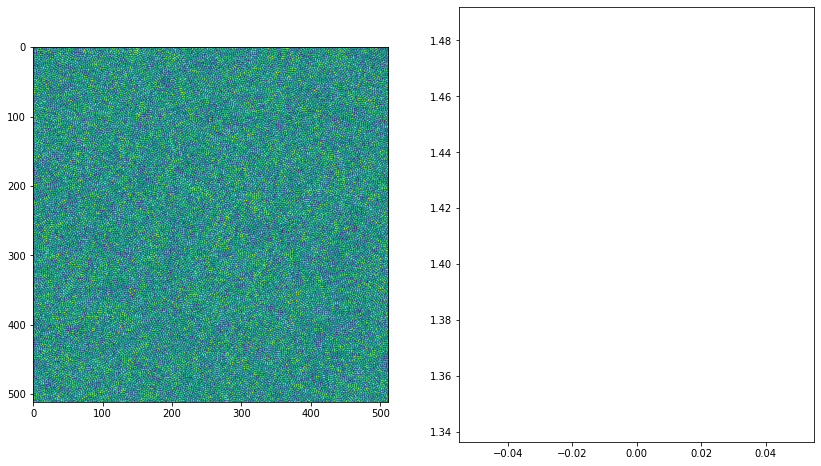

In [757]:
max_iter = 1
accs = []

objxTF = (fft2(guess_amplitude * np.exp(1j*guess_phase))*TF)

for i in range(max_iter):
  cal_phase = np.angle(ifft2(objxTF))
  exp_new = exp_data * np.exp(1j*cal_phase)
  objxTF_new = fft2(exp_new)
  guess_phase = guess_phase + np.conj(TF)/np.amax(np.abs(TF)**2) * (objxTF_new-objxTF) 
  acc = (guess_phase*true_phase).sum() / np.sqrt((guess_phase*guess_phase).sum() * (true_phase*true_phase).sum())
  accs.append(acc)

f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(result_phase)
ax[1].plot(accs)

0.999993819258981215


/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


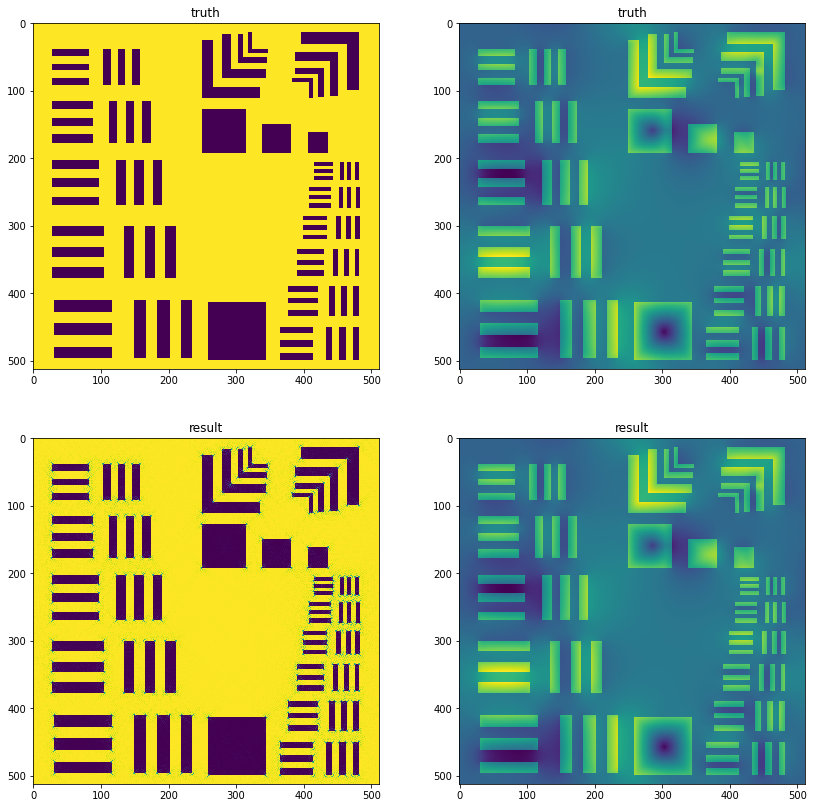

In [683]:
guess_amplitude = np.copy(true_amplitude)
guess_phase = np.copy(true_phase)

t0 = (guess_amplitude*np.exp(1j*guess_phase)).astype(np.complex256)

#exp_data =  np.abs(ifft2(ifftshift(fftshift(fft2(t0))*TF, axes=(1,2))))
exp_data =  np.abs(ifft2(fft2(t0)*TF))
TF2 = np.copy(TF)
TF2[np.abs(TF)<1e-14]=1e7
#test = ifft2(ifftshift(fftshift(fft2(t0))*TF, axes=(1,2)))
test1 = t0
test2 = ifft2(fft2(ifft2(fft2(t0)*TF[0]))/TF2)[0]


f, ax = plt.subplots(ncols=2,nrows=2, figsize = (14,14))
ax[0,0].imshow(np.abs(test1), interpolation='none', norm=colors.LogNorm())
ax[0,0].set_title("truth")
ax[1,0].imshow(np.abs(test2), interpolation='none', norm=colors.LogNorm(np.abs(test1).min(),np.abs(test1).max()))
ax[1,0].set_title("result")
ax[0,1].imshow(np.angle(test1), interpolation='none')
ax[0,1].set_title("truth")
ax[1,1].imshow(np.angle(test2), interpolation='none')
ax[1,1].set_title("result");

test1 = np.angle(test1)
test2 = np.angle(test2)
acc = (test1*test2).sum() / np.sqrt((test1*test1).sum() * (test2*test2).sum())
print(acc)

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


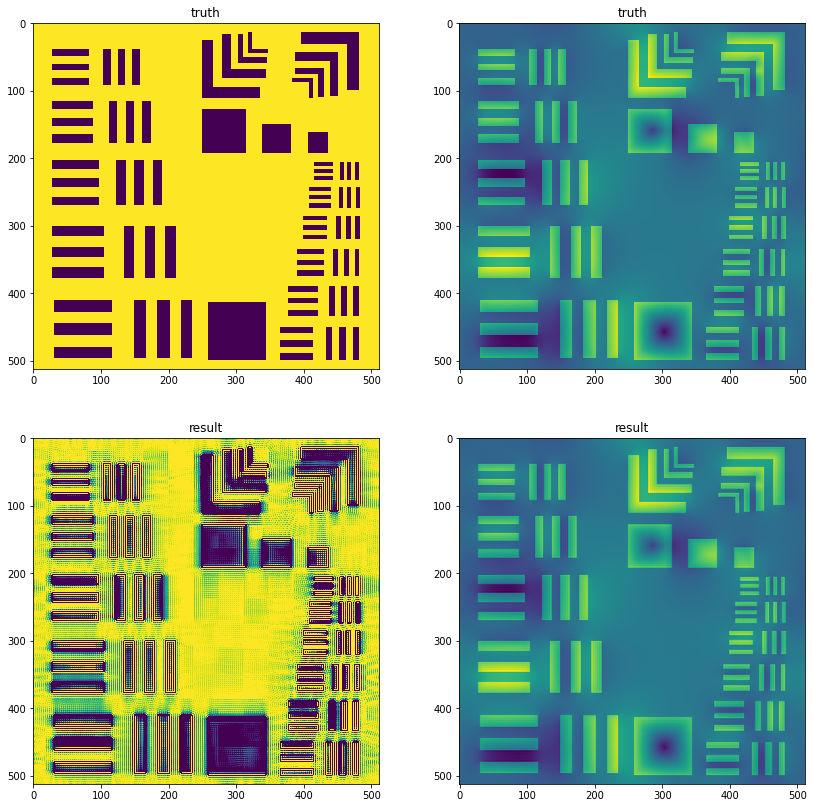

In [747]:
obj_new = (guess_amplitude * np.exp(1j*guess_phase)).astype(np.complex256)
cal_phase = np.angle(ifft2(fft2(obj_new)*TF))
exp_new = exp_data * np.exp(1j*cal_phase)
test2 = ifft2(fft2(exp_new)/TF2)[0]
test1 = obj_new


f, ax = plt.subplots(ncols=2,nrows=2, figsize = (14,14))
ax[0,0].imshow(np.abs(test1), interpolation='none', norm=colors.LogNorm())
ax[0,0].set_title("truth")
ax[1,0].imshow(np.abs(test2), interpolation='none', norm=colors.LogNorm(np.abs(test1).min(),np.abs(test1).max()))
ax[1,0].set_title("result")
ax[0,1].imshow(np.angle(test1), interpolation='none')
ax[0,1].set_title("truth")
ax[1,1].imshow(np.angle(test2), interpolation='none')
ax[1,1].set_title("result");

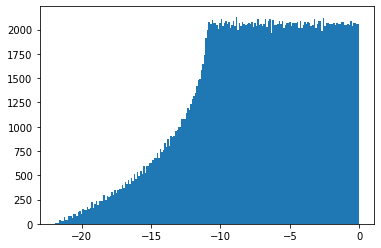

In [723]:
TF = fftshift(tf_microscope[selection], axes=(1,2))
plt.hist(np.log10(np.abs(TF[1])).flatten(), bins=200);

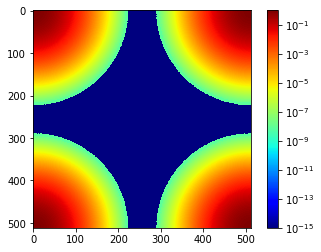

In [750]:
plt.imshow(np.abs(TF[0]), norm=colors.LogNorm(vmin=1e-15), cmap="jet")
plt.colorbar()

In [271]:
guess_amplitude = denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False)
# initialize the phase as 0.5 everywhere
#guess_phase = np.zeros(A_samples[32].shape)+0.5
guess_phase = np.copy(true_phase)

In [269]:
cal_old = fftshift(ifft2(TF*fftshift(fft2(guess_amplitude*np.exp(1j*guess_phase)))))
exp_new = exp_data*np.exp(1j*np.angle(cal_old))
guess_phase = np.angle(ifft2(fftshift(fft2(exp_new)/TF))).mean(0)

In [270]:
acc = (guess_phase*true_phase).sum() / np.sqrt((guess_phase*guess_phase).sum() * (true_phase*true_phase).sum())
print(acc)

0.003099526690650075


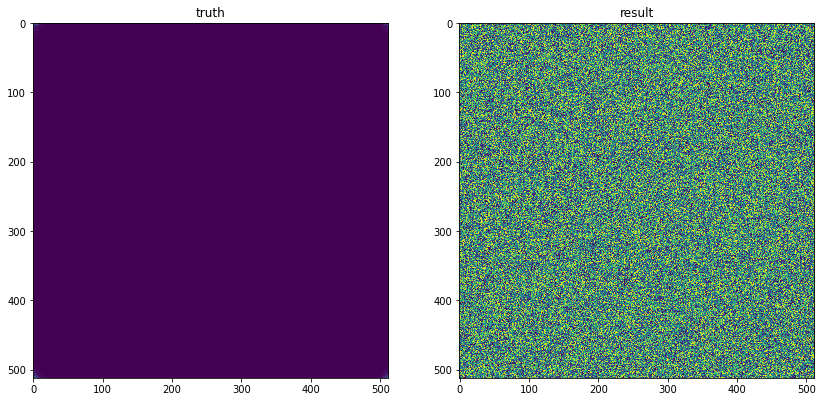

In [336]:
cal_old = ifft2(TF*fftshift(fft2(true_amplitude*np.exp(1j*true_phase))))
exp_new = exp_data*np.exp(1j*np.angle(cal_old))
ttt = ((fft2(exp_new))/TF)[0]

f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(np.abs(ttt), interpolation='none')
ax[0].set_title("truth")
ax[1].imshow(np.angle(ttt), interpolation='none')
ax[1].set_title("result");

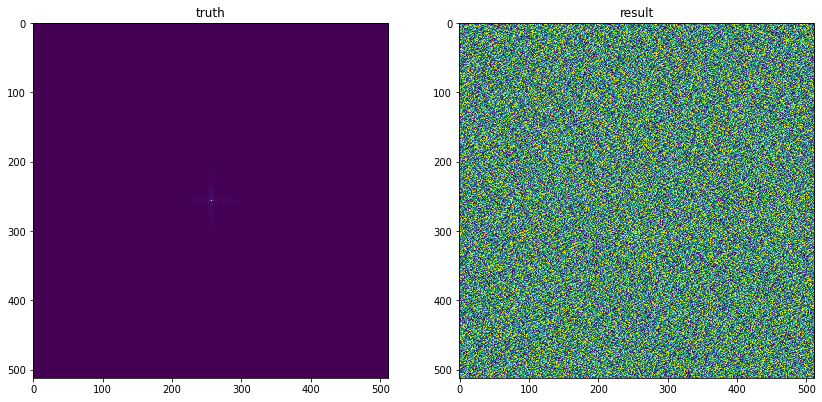

In [334]:
tt = (fftshift(fft2(true_amplitude*np.exp(1j*true_phase))))

f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(np.abs(tt), interpolation='none')
ax[0].set_title("truth")
ax[1].imshow(np.angle(tt), interpolation='none')
ax[1].set_title("result");

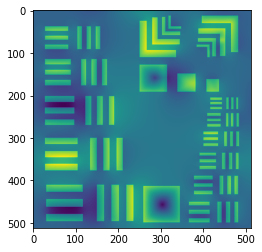

In [322]:
plt.imshow(true_phase)

In [292]:
np.abs(cal_old[0])

array([[1.0996526, 1.0998081, 1.0994343, ..., 1.0987289, 1.0984732,
        1.0990072],
       [1.099406 , 1.0996544, 1.0995382, ..., 1.0990797, 1.0987499,
        1.0989643],
       [1.0991253, 1.099436 , 1.099573 , ..., 1.0995578, 1.0991254,
        1.0989455],
       ...,
       [1.099607 , 1.0994852, 1.0989977, ..., 1.0990696, 1.09876  ,
        1.0991704],
       [1.0997818, 1.0997123, 1.0991042, ..., 1.0987133, 1.0984792,
        1.0991365],
       [1.099794 , 1.0998319, 1.0992715, ..., 1.0985931, 1.0983734,
        1.0990719]], dtype=float32)

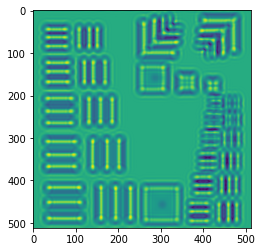

In [291]:
plt.imshow(exp_data[0],vmin=exp_data[0].min(), vmax=exp_data[0].max())

In [293]:
exp_data[0]

array([[1.09965261, 1.09980786, 1.09943395, ..., 1.09872887, 1.09847304,
        1.09900717],
       [1.09940622, 1.0996545 , 1.09953812, ..., 1.09907943, 1.09874995,
        1.09896443],
       [1.09912525, 1.09943594, 1.0995729 , ..., 1.0995577 , 1.09912554,
        1.09894555],
       ...,
       [1.09960709, 1.09948504, 1.09899763, ..., 1.09906959, 1.09875998,
        1.09917037],
       [1.09978162, 1.09971205, 1.09910427, ..., 1.09871337, 1.09847911,
        1.09913648],
       [1.09979415, 1.09983202, 1.09927165, ..., 1.09859331, 1.09837345,
        1.09907187]])